In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation as LDA   
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC

from time import time
from wordcloud import WordCloud

In [2]:
# Import dataset
df = pd.read_csv('data/preprocessed_data.csv')

# Train-Test Split

In [3]:
# Remove stopwords
stop = stopwords.words('english')

# Include other words that occur frequently
newStopWords = ['blush','nars','orgasm','colour','color']
stop.extend(newStopWords)

df['review_processed_stop'] = df['review_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [4]:
X = df.drop(['repurchase_again','date','review_length'], axis=1)
y = df['repurchase_again']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# create dictionary which maps each token to its corresponding tf-idf score to get more domain specific stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words=stop)
X_train_dtm = vect.fit_transform(X_train['review_processed_stop'])
word2tfidf = dict(zip(vect.get_feature_names(), vect.idf_))
domain_specific_stopwords = sorted(word2tfidf, key = word2tfidf.get)[:40]

In [6]:
domain_specific_stopwords

['look',
 'skin',
 'like',
 'love',
 'would',
 'pink',
 'really',
 'wa',
 'shimmer',
 'one',
 'give',
 'much',
 'product',
 'use',
 'cheek',
 'natural',
 'think',
 'great',
 'doe',
 'get',
 'glow',
 'go',
 'pretty',
 'ha',
 'pigmented',
 'little',
 'make',
 'light',
 'tone',
 'last',
 'time',
 'peachy',
 'day',
 'good',
 'well',
 'nice',
 'beautiful',
 'brush',
 'perfect',
 'face']

In [7]:
# Exclude stopwords that could help in determining if one will repurchase
domain_specific_stopwords = list(filter(lambda x: x not in ['like', 'love', 'great', 'pretty', 'good', 'beautiful', 'nice', 'perfect'], domain_specific_stopwords))

# Include more domain specific stop words
stop.extend(domain_specific_stopwords)

In [8]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lda', LDA(learning_method='online', learning_offset=50., random_state=0)),
])

# Define parameters to tune
parameters = {
    'vect__use_idf': (True, False),
    'vect__max_df': (0.85, 0.9, 0.95),
    'vect__min_df': (0.01, 0.03, 0.05),
    'vect__stop_words': (None, stop, 'english'),
    'vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
    'lda__n_components': (3, 4, 5, 6),
    'lda__learning_decay': (.5, .7, .9),
    'lda__max_iter': (5,10,50,100)
}

lda_randomsearch = RandomizedSearchCV(pipeline, param_distributions=parameters, cv=5, n_jobs=-1, verbose=1, random_state=0,return_train_score=True)

#t0 = time()

# Do the Randomized Search
lda_randomsearch.fit(X_train['review_processed'])

#print("done in %0.3fs" % (time() - t0))
print("Best Model's Params: ", lda_randomsearch.best_params_)
print("Best Log Likelihood Score: ", lda_randomsearch.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Model's Params:  {'vect__use_idf': True, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'a

In [9]:
# Save to file
joblib.dump(lda_randomsearch, 'models/lda_randomsearch.pkl')

['models/lda_randomsearch.pkl']

In [10]:
# Using best estimator for tf-idf vectorizer to do topic modeling
tfidf_vectorizer = lda_randomsearch.best_estimator_[0]
X_train_dtm = tfidf_vectorizer.transform(X_train['review_processed'])
X_test_dtm = tfidf_vectorizer.transform(X_test['review_processed'])

In [11]:
X_train_dtm.shape

(5029, 123)

In [12]:
# Using best estimator for LDA model to do topic modeling
best_lda_model = lda_randomsearch.best_estimator_[1]
X_train_LDA = best_lda_model.transform(X_train_dtm)
X_test_LDA = best_lda_model.transform(X_test_dtm)

# Column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

In [13]:
### Train Data ###

# index names
docnames_train = ["TrainDoc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic_train = pd.DataFrame(np.round(X_train_LDA, 2), columns=topicnames, index=docnames_train)

# Get dominant topic for each document
dominant_topic_train = np.argmax(df_document_topic_train.values, axis=1)
df_document_topic_train['dominant_topic'] = dominant_topic_train
print(df_document_topic_train.head())
print('\nDistribution of topics')
print(df_document_topic_train['dominant_topic'] .value_counts())

           Topic0  Topic1  Topic2  Topic3  dominant_topic
TrainDoc0    0.08    0.46    0.39    0.08               1
TrainDoc1    0.20    0.07    0.06    0.67               3
TrainDoc2    0.60    0.14    0.13    0.13               0
TrainDoc3    0.25    0.25    0.25    0.25               0
TrainDoc4    0.82    0.06    0.06    0.06               0

Distribution of topics
3    1867
1    1217
0    1194
2     751
Name: dominant_topic, dtype: int64


In [14]:
### Test Data

# index names
docnames_test = ["TestDoc" + str(i) for i in range(len(X_test))]

# Make the pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(X_test_LDA, 2), columns=topicnames, index=docnames_test)

# Get dominant topic for each document
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)
df_document_topic_test['dominant_topic'] = dominant_topic_test
print(df_document_topic_test.head())
print('\nDistribution of topics')
print(df_document_topic_test['dominant_topic'] .value_counts())

          Topic0  Topic1  Topic2  Topic3  dominant_topic
TestDoc0    0.43    0.05    0.05    0.47               3
TestDoc1    0.06    0.06    0.06    0.82               3
TestDoc2    0.06    0.06    0.06    0.81               3
TestDoc3    0.18    0.13    0.20    0.49               3
TestDoc4    0.11    0.11    0.11    0.67               3

Distribution of topics
3    616
1    401
0    389
2    271
Name: dominant_topic, dtype: int64


In [15]:
from sklearn.decomposition import TruncatedSVD
clusters = dominant_topic_train
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(X_train_LDA)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

Text(0.5, 1.0, 'Segregation of Topic Clusters')

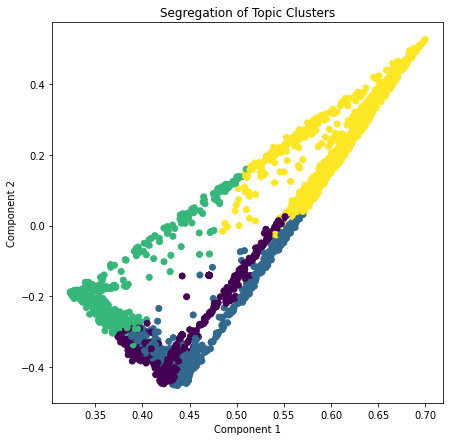

In [16]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

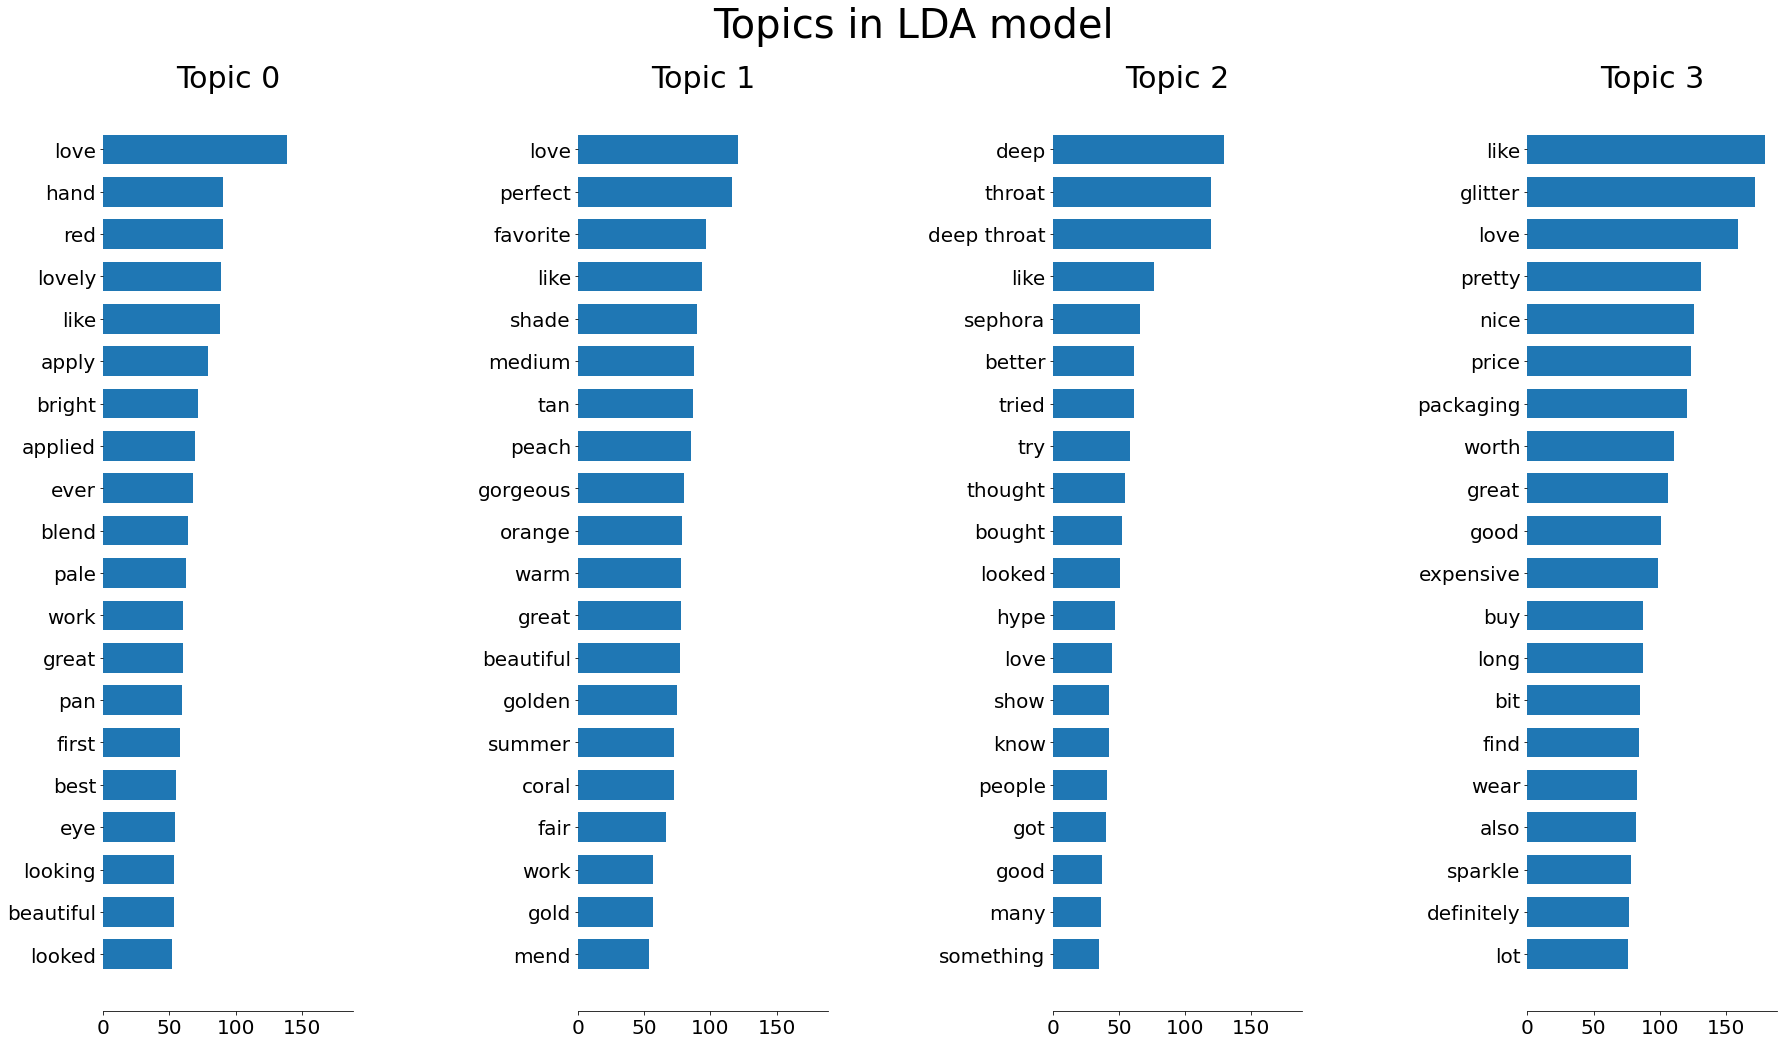

In [17]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
words = tfidf_vectorizer.get_feature_names()
plot_top_words(best_lda_model, words, n_top_words, 'Topics in LDA model')

In [18]:
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [19]:
# Add topic feature into products
X_train['dominant_topic'] = dominant_topic_train
X_test['dominant_topic'] = dominant_topic_test

In [20]:
X_train['dominant_topic'].value_counts()

3    1867
1    1217
0    1194
2     751
Name: dominant_topic, dtype: int64

In [21]:
X_test['dominant_topic'].value_counts()

3    616
1    401
0    389
2    271
Name: dominant_topic, dtype: int64

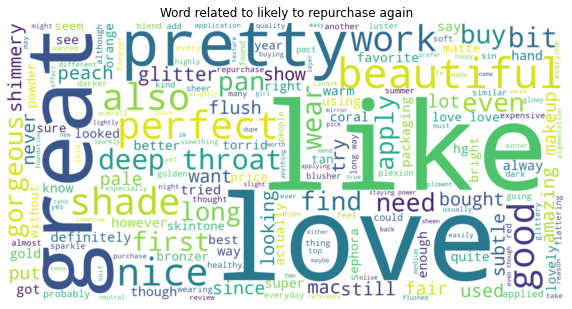

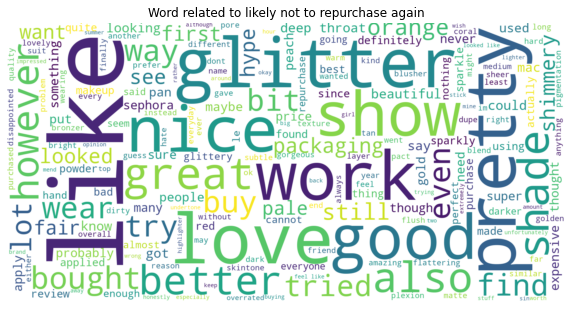

In [22]:
# Wordcloud
repurchase_products = df[df['repurchase_again'] == 1]
donot_repurchase_products = df[df['repurchase_again'] == 0]
repurchase_reviews = " ".join(r for r in repurchase_products['review_processed_stop'])
donot_repurchase_reviews = " ".join(r for r in donot_repurchase_products['review_processed_stop'])

# Create and generate a word cloud image that excludes domain-specific and common stopwords
repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(repurchase_reviews)
donot_repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(donot_repurchase_reviews)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely to repurchase again")
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(donot_repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely not to repurchase again")
plt.show()

In [23]:
# Export files
X_train.reset_index(drop=True).to_csv('data/X_train.csv', index=None)
X_test.reset_index(drop=True).to_csv('data/X_test.csv', index=None)
y_train.reset_index(drop=True).to_csv('data/y_train.csv', index=None)
y_test.reset_index(drop=True).to_csv('data/y_test.csv', index=None)

# Model Building

In [24]:
# Check class distribution
y_train.value_counts()

1    3811
0    1218
Name: repurchase_again, dtype: int64

In [25]:
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return x.drop(['review','review_processed','review_processed_stop'],axis=1)

def get_text_data(x):
    return x['review_processed']

transformer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [26]:
# Training config
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scoring = {'Recall': 'recall', 'Precision': 'precision', 'ROC_AUC': 'roc_auc', 'F1': 'f1_macro'}
refit = 'F1'

## Logistic Regression

In [27]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('logreg', LogisticRegression(solver='liblinear', random_state=0))
])

# Randomized Search Parameters for Log Reg
param_grid = {
              'features__text_features__vect__use_idf': (True, False),
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'logreg__C': (0.01, 1, 10),
              'logreg__penalty': ('l1', 'l2'),
             }


# Perform Randomized Search
logreg = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

logreg.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x7fe9443d1ef0>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get...
                                                                                       'his',
                                                   

In [28]:
# Check the best params chosen
logreg.best_params_

{'logreg__penalty': 'l2',
 'logreg__C': 10,
 'features__text_features__vect__use_idf': False,
 'features__text_features__vect__stop_words': None,
 'features__text_features__vect__ngram_range': (1, 2),
 'features__text_features__vect__min_df': 0.01,
 'features__text_features__vect__max_df': 1.0}

In [29]:
# Number of words from TFIDF Vectorizer
len(logreg.best_estimator_['features'].transformer_list[1][1][1].get_feature_names())

1735

In [30]:
# Number of features chosen
np.sum(logreg.best_estimator_['feature_selection'].get_support())

406

In [31]:
# Total number of features
len(logreg.best_estimator_['feature_selection'].get_support())

1764

In [32]:
# Save to file
joblib.dump(logreg, 'models/logreg.pkl')

['models/logreg.pkl']

In [71]:
# Model prediction
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_proba = logreg.predict_proba(X_test)[:, 1]

## SVM

In [33]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('svm', SVC(probability=True, random_state=0))
])

# Randomized Search Parameters for SVM
param_grid = {
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'svm__C': (0.1, 1, 10), 
              'svm__gamma': (1, 0.1, 0.01),
              'svm__kernel': ('linear', 'rbf', 'poly', 'sigmoid')
             }


# Perform Randomized Search
svm = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

svm.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x7fe9443d1ef0>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get...
                                                                                       'he',
                                                    

In [34]:
# Check the best params chosen
svm.best_params_

{'svm__kernel': 'rbf',
 'svm__gamma': 1,
 'svm__C': 10,
 'features__text_features__vect__stop_words': None,
 'features__text_features__vect__ngram_range': (1, 2),
 'features__text_features__vect__min_df': 0.01,
 'features__text_features__vect__max_df': 0.75}

In [35]:
# Number of words from TFIDF Vectorizer
len(svm.best_estimator_['features'].transformer_list[1][1][1].get_feature_names())

1729

In [36]:
# Number of features chosen
np.sum(svm.best_estimator_['feature_selection'].get_support())

405

In [37]:
# Total number of features
len(svm.best_estimator_['feature_selection'].get_support())

1758

In [38]:
# Save to file
joblib.dump(svm, 'models/svm.pkl')

['models/svm.pkl']

In [72]:
# Model prediction
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

## Naive Bayes

In [39]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('nb', MultinomialNB())
])

# Randomized Search Parameters for Naive Bayes
param_grid = {
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'nb__alpha': (0.0001, 0.01, 1, 10)
             }


# Perform Randomized Search
nb = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

nb.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x7fe9443d1ef0>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get...
                                                                                       "you've",
                                                

In [40]:
# Check the best params chosen
nb.best_params_

{'nb__alpha': 0.01,
 'features__text_features__vect__stop_words': None,
 'features__text_features__vect__ngram_range': (1, 2),
 'features__text_features__vect__min_df': 0.01,
 'features__text_features__vect__max_df': 0.5}

In [41]:
# Number of words from TFIDF Vectorizer
len(nb.best_estimator_['features'].transformer_list[1][1][1].get_feature_names())

1718

In [42]:
# Number of features chosen
np.sum(nb.best_estimator_['feature_selection'].get_support())

423

In [43]:
# Total number of features
len(nb.best_estimator_['feature_selection'].get_support())

1747

In [44]:
# Save to file
joblib.dump(nb, 'models/nb.pkl')

['models/nb.pkl']

In [73]:
# Model prediction
y_pred_nb = nb.predict(X_test)
y_pred_nb_proba = nb.predict_proba(X_test)[:, 1]

# Stacking (model not exported, to remove?)

In [67]:
from mlxtend.classifier import StackingClassifier
sclf = StackingClassifier(classifiers=[logreg, svm, nb], 
                          meta_classifier=LogisticRegression(), fit_base_estimators=False)

sclf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/mlxtend/classifier/stacking_classification.py:160: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


StackingClassifier(classifiers=[RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                                                   estimator=Pipeline(steps=[('features',
                                                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                                                              Pipeline(steps=[('selector',
                                                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x7fe9443d1ef0>))])),
                                                                                                             ('text_features',
                                                                                                              Pipeline(steps=[('selector',
                                                          

In [68]:
# Model prediction
y_pred_sclf = sclf.predict(X_test)
y_pred_sclf_proba = sclf.predict_proba(X_test)[:, 1]

In [69]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_sclf))
print('Precision:', precision_score(y_test, y_pred_sclf))
print('Recall:', recall_score(y_test, y_pred_sclf))
print('F1:', f1_score(y_test, y_pred_sclf, average='macro'))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_sclf_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_sclf))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_sclf))

Accuracy: 0.8425760286225402
Precision: 0.8654970760233918
Recall: 0.9367088607594937
F1: 0.7670225395515665
ROC_AUC: 0.8182161246820119

Confusion Matrix:
[[ 229  184]
 [  80 1184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.87      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.75      0.77      1677
weighted avg       0.83      0.84      0.83      1677



# Stacking with tuning

In [74]:
# Predictions for train datasets and convert to dataframe
y_pred_logreg_train = pd.DataFrame(logreg.predict(X_train))
y_pred_svm_train = pd.DataFrame(svm.predict(X_train))
y_pred_nb_train = pd.DataFrame(nb.predict(X_train))

# Convert test datasets into dataframe
y_pred_logreg = pd.DataFrame(y_pred_logreg)
y_pred_svm = pd.DataFrame(y_pred_svm)
y_pred_nb = pd.DataFrame(y_pred_nb)

In [75]:
# Concatenate the predictions for both train and test datasets for all 3 models
df_train = pd.concat([y_pred_logreg_train, y_pred_svm_train, y_pred_nb_train],axis=1)
df_test = pd.concat([y_pred_logreg, y_pred_svm, y_pred_nb], axis=1)

In [76]:
from sklearn.model_selection import GridSearchCV
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('logreg', LogisticRegression(solver='liblinear', random_state=0))
])

# Randomized Search Parameters for Log Reg
param_grid = {
              'logreg__C': (0.01, 1, 10),
              'logreg__penalty': ('l1', 'l2'),
             }


# Perform Grid Search
stack_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, return_train_score=True)

stack_model.fit(df_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': (0.01, 1, 10),
                         'logreg__penalty': ('l1', 'l2')},
             refit='F1', return_train_score=True,
             scoring={'F1': 'f1_macro', 'Precision': 'precision',
                      'ROC_AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=1)

In [77]:
# Save to file
joblib.dump(stack_model, 'models/stack_model.pkl')

['models/stack_model.pkl']

# Bagging (Logistic Regression)

In [46]:
# Load file
logreg = joblib.load('models/logreg.pkl')

In [47]:
# Get best TF-IDF Vectorizer for Logistic Regression
logreg_vectorizer = logreg.best_estimator_['features'].transformer_list[1][1]['vect']
logreg_model = logreg.best_estimator_['logreg']

In [48]:
# Vectorize review_processed
X_train_dtm = logreg_vectorizer.fit_transform(X_train['review_processed'])
X_test_dtm = logreg_vectorizer.transform(X_test['review_processed'])

# Drop review_processed
X_train_numeric = X_train.drop(['review','review_processed','review_processed_stop'], axis = 1)
X_test_numeric = X_test.drop(['review','review_processed','review_processed_stop'], axis = 1)

# Extract column names from numeric and vectorizer
column_names = list(X_train_numeric.columns) + logreg_vectorizer.get_feature_names()

# Combine review_processed vector with other X_test numeric columns
X_train_combined = pd.DataFrame(np.hstack((X_train_numeric, X_train_dtm.toarray())), columns = column_names)
X_test_combined = pd.DataFrame(np.hstack((X_test_numeric, X_test_dtm.toarray())), columns = column_names)

# Export files
X_train_combined.to_csv('data/X_train_vectorized_logreg.csv', index=None)
X_test_combined.to_csv('data/X_test_vectorized_logreg.csv', index=None)

In [49]:
# Fit bagging classifier
logreg_bagging = BaggingClassifier(logreg_model, max_samples=0.5, max_features=0.5)
logreg_bagging.fit(X_train_combined,y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=10, random_state=0,
                                                    solver='liblinear'),
                  max_features=0.5, max_samples=0.5)

In [50]:
# Save to file
joblib.dump(logreg_bagging, 'models/logreg_bagging.pkl')

['models/logreg_bagging.pkl']

# Bagging (SVM)

In [51]:
# Load file
svm = joblib.load('models/svm.pkl')

In [52]:
# Get best TF-IDF Vectorizer for Logistic Regression
svm_vectorizer = svm.best_estimator_['features'].transformer_list[1][1]['vect']
svm_model = svm.best_estimator_['svm']

In [53]:
# Vectorize review_processed
X_train_dtm = svm_vectorizer.fit_transform(X_train['review_processed'])
X_test_dtm = svm_vectorizer.transform(X_test['review_processed'])

# Drop review_processed
X_train_numeric = X_train.drop(['review','review_processed','review_processed_stop'], axis = 1)
X_test_numeric = X_test.drop(['review','review_processed','review_processed_stop'], axis = 1)

# Extract column names from numeric and vectorizer
column_names = list(X_train_numeric.columns) + svm_vectorizer.get_feature_names()

# Combine review_processed vector with other X_test numeric columns
X_train_combined = pd.DataFrame(np.hstack((X_train_numeric, X_train_dtm.toarray())), columns = column_names)
X_test_combined = pd.DataFrame(np.hstack((X_test_numeric, X_test_dtm.toarray())), columns = column_names)

# Export files
X_train_combined.to_csv('data/X_train_vectorized_svm.csv', index=None)
X_test_combined.to_csv('data/X_test_vectorized_svm.csv', index=None)

In [54]:
# Fit bagging classifier
svm_bagging = BaggingClassifier(svm_model, max_samples=0.5, max_features=0.5)
svm_bagging.fit(X_train_combined,y_train)

BaggingClassifier(base_estimator=SVC(C=10, gamma=1, probability=True,
                                     random_state=0),
                  max_features=0.5, max_samples=0.5)

In [55]:
# Save to file
joblib.dump(svm_bagging, 'models/svm_bagging.pkl')

['models/svm_bagging.pkl']

# Bagging (Naive Bayes)

In [56]:
# Load file
nb = joblib.load('models/nb.pkl')

In [57]:
# Get best TF-IDF Vectorizer for Logistic Regression
nb_vectorizer = nb.best_estimator_['features'].transformer_list[1][1]['vect']
nb_model = nb.best_estimator_['nb']

In [58]:
# Vectorize review_processed
X_train_dtm = nb_vectorizer.fit_transform(X_train['review_processed'])
X_test_dtm = nb_vectorizer.transform(X_test['review_processed'])

# Drop review_processed
X_train_numeric = X_train.drop(['review','review_processed','review_processed_stop'], axis = 1)
X_test_numeric = X_test.drop(['review','review_processed','review_processed_stop'], axis = 1)

# Extract column names from numeric and vectorizer
column_names = list(X_train_numeric.columns) + nb_vectorizer.get_feature_names()

# Combine review_processed vector with other X_test numeric columns
X_train_combined = pd.DataFrame(np.hstack((X_train_numeric, X_train_dtm.toarray())), columns = column_names)
X_test_combined = pd.DataFrame(np.hstack((X_test_numeric, X_test_dtm.toarray())), columns = column_names)

# Export files
X_train_combined.to_csv('data/X_train_vectorized_nb.csv', index=None)
X_test_combined.to_csv('data/X_test_vectorized_nb.csv', index=None)

In [59]:
# Fit bagging classifier
nb_bagging = BaggingClassifier(nb_model, max_samples=0.5, max_features=0.5)
nb_bagging.fit(X_train_combined,y_train)

BaggingClassifier(base_estimator=MultinomialNB(alpha=0.01), max_features=0.5,
                  max_samples=0.5)

In [60]:
# Save to file
joblib.dump(nb_bagging, 'models/nb_bagging.pkl')

['models/nb_bagging.pkl']

# Boosting (probably removing because even without tuning hyperparameters, we're getting 100% in our metrics, smells fishy!!)

In [61]:
# Load file
lda_randomsearch = joblib.load('models/lda_randomsearch.pkl')

In [62]:
# Best TF-IDF Vectorizer
vectorizer = lda_randomsearch.best_estimator_['vect']

In [63]:
# Vectorize review_processed
X_train_dtm = vectorizer.fit_transform(X_train['review_processed'])
X_test_dtm = vectorizer.transform(X_test['review_processed'])

# Drop review_processed
X_train_numeric = X_train.drop(['review','review_processed','review_processed_stop'], axis = 1)
X_test_numeric = X_test.drop(['review','review_processed','review_processed_stop'], axis = 1)

# Extract column names from numeric and vectorizer
column_names = list(X_train_numeric.columns) + vectorizer.get_feature_names()

# Combine review_processed vector with other X_test numeric columns
X_train_combined = pd.DataFrame(np.hstack((X_train_numeric, X_train_dtm.toarray())), columns = column_names)
X_test_combined = pd.DataFrame(np.hstack((X_test_numeric, X_test_dtm.toarray())), columns = column_names)

# Export files
X_train_combined.to_csv('data/X_train_vectorized.csv', index=None)
X_test_combined.to_csv('data/X_test_vectorized.csv', index=None)

In [64]:
# temporary function; used in model evaluation
def model_metrics(y_pred, y_pred_proba):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred, average='macro'))
    print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba))

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

In [65]:
# RandomForest
clf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)
print('\n-----Random Forest-----')
model_metrics(y_test, y_pred)


# AdaBoost
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)
print('\n-----AdaBoost-----')
model_metrics(y_test, y_pred)


# GradientBoosting
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)
print('\n-----Gradient Boosting-----')
model_metrics(y_test, y_pred)


-----Random Forest-----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC_AUC: 0.6667340316302449

Confusion Matrix:
[[ 413    0]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00      1264

    accuracy                           1.00      1677
   macro avg       1.00      1.00      1.00      1677
weighted avg       1.00      1.00      1.00      1677


-----AdaBoost-----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC_AUC: 0.7165020535139609

Confusion Matrix:
[[ 413    0]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00      1264

    accuracy                           1.00      1677
   macro avg       1.00      1.00      1.00      1677
weighted avg       1.00      1.00      1.00      1677


-----G